# Labor Market Intelligence Analysis

## KASS Notebook 07 | Applied Econometrics Series

**KRL Suite v2.0** | **Tier: Community** | **Data: BLS + FRED**

---

### Overview

This notebook demonstrates **comprehensive labor market intelligence** using descriptive econometric methods and real-time data from the Bureau of Labor Statistics (BLS) and Federal Reserve Economic Data (FRED).

### Learning Objectives

After completing this notebook, you will be able to:

1.  **Data Integration** - Combine employment, wage, and macroeconomic indicators from BLS and FRED APIs
2.  **Industry Analysis** - Apply Location Quotient and Shift-Share decomposition to identify regional specializations
3.  **Time Series Diagnostics** - Use STL decomposition to detect anomalies in labor market trends
4.  **Correlation Analysis** - Examine relationships between labor market indicators and economic conditions
5.  **Dashboard Creation** - Build executive-ready visualizations of labor market intelligence

### Key Methods

| Method | Purpose | KRL Component |
|--------|---------|---------------|
| Location Quotient | Regional industry specialization | `LocationQuotientModel` |
| Shift-Share Analysis | Decompose employment change | `ShiftShareModel` |
| STL Decomposition | Trend/seasonal/residual | `STLAnomalyModel` |
| Correlation Analysis | Cross-indicator relationships | `scipy.stats` |

### Prerequisites

- Python 3.9+
- KRL Suite Community Tier
- FRED API key (free registration at https://fred.stlouisfed.org/docs/api/api_key.html)
- BLS API key (optional, for higher rate limits)

### Estimated Time: 20-25 minutes

---

⚠️ **Analytical Framework Note:** This notebook performs **descriptive analytics**, not causal inference. Correlations and patterns identified should be interpreted as associations, not causal effects. See the Limitations section for proper interpretation guidance.

## Motivation

### Why Labor Market Intelligence Matters

Labor market dynamics are fundamental to understanding economic health, policy effectiveness, and workforce development needs. Policymakers, researchers, and business leaders require comprehensive intelligence that goes beyond simple unemployment statistics:

**1. Economic Monitoring**
- Track business cycle dynamics through employment and wage trends
- Identify early warning signs of labor market stress
- Monitor recovery patterns following economic shocks

**2. Regional Economic Development**
- Assess industry specialization and competitive advantage
- Identify skills gaps and training priorities
- Support evidence-based workforce investment decisions

**3. Policy Evaluation Context**
- Establish baseline labor market conditions for policy analysis
- Track leading and lagging indicators for impact timing
- Monitor distributional effects across sectors and regions

### Analytical Framework

This notebook implements a **descriptive analytics pipeline** for labor market intelligence:

```
Data Collection → Indicator Construction → Pattern Detection → Visualization
     ↓                    ↓                       ↓                ↓
  BLS/FRED          LQ, Shift-Share        STL Anomaly        Dashboards
```

**Important:** This is *descriptive*, not *causal* analysis. We identify patterns and correlations that inform decision-making but do not establish cause-and-effect relationships.

### Policy Applications

| Application | Descriptive Intelligence | Causal Analysis Needed |
|-------------|-------------------------|----------------------|
| Economic monitoring | ✅ This notebook | ❌ Not required |
| Training needs assessment | ✅ Partial (skill gaps) | ⚠️ For ROI claims |
| Regional planning | ✅ Industry analysis | ⚠️ For intervention effects |
| Policy evaluation | ⚠️ Context only | ✅ See causal inference notebooks |

### Data Sources

| Source | Variables | Update Frequency | Access |
|--------|-----------|------------------|--------|
| BLS CES | Employment by industry | Monthly | Free API |
| BLS QCEW | Wages, establishment counts | Quarterly | Free API |
| BLS OES | Occupation-level wages | Annual | Free API |
| FRED | GDP, CPI, macro indicators | Varies | Free API |

---

*For causal analysis of workforce interventions, see [22-workforce-development-roi.ipynb](22-workforce-development-roi.ipynb).*

# Labor Market Intelligence Analysis

## Executive Summary

This notebook provides **comprehensive labor market analysis** using the KRL Suite to combine BLS employment data with economic indicators from FRED.

### KRL Suite Components Used

- **krl_data_connectors.community**: `BLSBasicConnector`, `FREDBasicConnector`
- **krl_models**: `STLAnomalyModel` for detecting unusual labor market patterns
- **krl_core**: Logging utilities

### Key Intelligence Questions

1. What are the trends in employment and wages?
2. How does unemployment relate to other economic indicators?
3. What sectors show the strongest labor market dynamics?
4. What leading indicators predict labor market changes?

**Estimated Time:** 20-25 minutes  
**Difficulty:** Intermediate

## 1. Environment Setup

In [2]:
# =============================================================================
# Labor Market Intelligence: Environment Setup
# =============================================================================
import os
import sys
import warnings
from datetime import datetime
import importlib

# Add KRL package paths (handles spaces in path correctly)
_krl_base = os.path.expanduser("~/Documents/GitHub/KRL/Private IP")
for _pkg in ["krl-open-core/src", "krl-data-connectors/src", "krl-model-zoo-v2-2.0.0-community"]:
    _path = os.path.join(_krl_base, _pkg)
    if _path not in sys.path:
        sys.path.insert(0, _path)

# Load environment variables from .env file
from dotenv import load_dotenv
_env_path = os.path.expanduser("~/Documents/GitHub/KRL/Private IP/krl-tutorials/.env")
load_dotenv(_env_path)

# Force complete reload of KRL modules to pick up any changes
_modules_to_reload = [k for k in sys.modules.keys() if k.startswith(('krl_core', 'krl_data_connectors', 'krl_models'))]
for _mod in _modules_to_reload:
    del sys.modules[_mod]

import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

# =============================================================================
# KRL Suite Imports
# =============================================================================
from krl_data_connectors.community import (
    BLSBasicConnector,
    FREDBasicConnector,
)
from krl_models import LocationQuotientModel, ShiftShareModel, STLAnomalyModel
from krl_core import get_logger

warnings.filterwarnings('ignore', category=FutureWarning)
logger = get_logger("LaborMarketIntelligence")

# Colorblind-safe palette
COLORBLIND_SAFE = ['#0072B2', '#E69F00', '#009E73', '#CC79A7', '#56B4E9', '#D55E00']

print("=" * 65)
print("👷 Labor Market Intelligence Analysis")
print("=" * 65)
print(f"📅 Execution Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🔑 FRED API Key: {'✓ Loaded' if os.getenv('FRED_API_KEY') else '✗ Not found'}")
print("=" * 65)

👷 Labor Market Intelligence Analysis
📅 Execution Time: 2025-11-28 04:34:19
🔑 FRED API Key: ✓ Loaded


In [3]:
# =============================================================================
# Initialize KRL Data Connectors
# =============================================================================
bls = BLSBasicConnector()
fred = FREDBasicConnector()

print("✓ KRL Data Connectors initialized:")
print(f"   • BLSBasicConnector - Labor statistics")
print(f"   • FREDBasicConnector - Economic indicators")

print(f"\n📊 Available BLS Series (Community Tier):")
print(f"   • LNS14000000 - Unemployment Rate")
print(f"   • CUUR0000SA0 - CPI All Urban Consumers")
print(f"   • CES0000000001 - Total Nonfarm Employment")

{"timestamp": "2025-11-28T09:34:26.388610Z", "level": "WARNING", "name": "BLSBasicConnector", "message": "No API key provided", "source": {"file": "base_connector.py", "line": 74, "function": "__init__"}, "levelname": "WARNING", "taskName": "Task-39", "connector": "BLSBasicConnector"}
{"timestamp": "2025-11-28T09:34:26.389056Z", "level": "INFO", "name": "BLSBasicConnector", "message": "Connector initialized", "source": {"file": "base_connector.py", "line": 81, "function": "__init__"}, "levelname": "INFO", "taskName": "Task-39", "connector": "BLSBasicConnector", "cache_dir": "/Users/bcdelo/.krl_cache/blsbasicconnector", "cache_ttl": 3600, "has_api_key": false}
{"timestamp": "2025-11-28T09:34:26.389590Z", "level": "INFO", "name": "BLSBasicConnector", "message": "Initialized BLS Basic connector (Community tier)", "source": {"file": "bls_basic.py", "line": 89, "function": "__init__"}, "levelname": "INFO", "taskName": "Task-39", "available_series": 8}
{"timestamp": "2025-11-28T09:34:26.3913

## 2. Fetch Labor Market Data

Collect comprehensive labor market indicators from BLS and FRED.

In [ ]:
# =============================================================================
# Fetch Labor Market Data from KRL Connectors
# =============================================================================
# NOTE: This notebook requires valid API credentials. No demo/fallback mode.
# Obtain BLS API key: https://data.bls.gov/registrationEngine/
# Obtain FRED API key: https://fred.stlouisfed.org/docs/api/api_key.html

# Get unemployment rate from BLS
try:
    unemployment = bls.get_unemployment_rate()
    print(f"✓ BLS Unemployment Rate: {len(unemployment)} observations")
except Exception as e:
    raise RuntimeError(
        f"BLS API connection failed: {e}\n\n"
        "⚠️ REPRODUCIBILITY REQUIREMENT: This notebook requires live API access.\n"
        "   1. Set environment variable: BLS_API_KEY=your_key_here\n"
        "   2. Obtain key from: https://data.bls.gov/registrationEngine/\n"
        "   3. Simulated data is NOT acceptable for institutional analysis.\n"
        "   For methods demonstration with synthetic data, see notebook 11 or 14."
    )

# Get CPI from BLS
try:
    cpi_data = bls.get_cpi()
    print(f"✓ BLS CPI: {len(cpi_data)} observations")
except Exception as e:
    raise RuntimeError(
        f"BLS CPI retrieval failed: {e}\n\n"
        "⚠️ REPRODUCIBILITY REQUIREMENT: CPI data required for real wage analysis.\n"
        "   Ensure BLS_API_KEY is set and has proper access permissions."
    )

# Get GDP from FRED for economic context
try:
    gdp_data = fred.get_series('GDP', start_year=2015, end_year=2024)
    print(f"✓ FRED GDP: {len(gdp_data)} observations")
except Exception as e:
    raise RuntimeError(
        f"FRED API connection failed: {e}\n\n"
        "⚠️ REPRODUCIBILITY REQUIREMENT: FRED data required for economic context.\n"
        "   1. Set environment variable: FRED_API_KEY=your_key_here\n"
        "   2. Obtain key from: https://fred.stlouisfed.org/docs/api/api_key.html"
    )

print(f"\n✓ Labor market data collection complete")

{"timestamp": "2025-11-28T09:34:30.769918Z", "level": "INFO", "name": "BLSBasicConnector", "message": "Fetching BLS series: LNS14000000", "source": {"file": "bls_basic.py", "line": 196, "function": "get_series"}, "levelname": "INFO", "taskName": "Task-42", "series_id": "LNS14000000", "start_year": 2016, "end_year": 2025}
{"timestamp": "2025-11-28T09:34:30.989171Z", "level": "INFO", "name": "BLSBasicConnector", "message": "Retrieved 117 observations for LNS14000000", "source": {"file": "bls_basic.py", "line": 242, "function": "get_series"}, "levelname": "INFO", "taskName": "Task-42", "series_id": "LNS14000000", "rows": 117}
✓ BLS Unemployment Rate: 117 observations
{"timestamp": "2025-11-28T09:34:30.990083Z", "level": "INFO", "name": "BLSBasicConnector", "message": "Fetching BLS series: CUUR0000SA0", "source": {"file": "bls_basic.py", "line": 196, "function": "get_series"}, "levelname": "INFO", "taskName": "Task-42", "series_id": "CUUR0000SA0", "start_year": 2016, "end_year": 2025}
{"ti

## 3. Metro-Level Labor Market Dataset

Build a comprehensive metro-level dataset with employment, wages, skills, and automation exposure metrics.

In [5]:
# =============================================================================
# Generate Metro-Level Labor Market Dataset
# =============================================================================
from sklearn.preprocessing import MinMaxScaler

def generate_labor_market_data(n_metros: int = 100, seed: int = 42) -> pd.DataFrame:
    """
    Generate synthetic metro-level labor market data.
    """
    np.random.seed(seed)
    
    # Latent labor market health
    base_health = np.random.beta(3, 2.5, n_metros)
    
    metros = [f'Metro_{i:03d}' for i in range(n_metros)]
    
    data = pd.DataFrame({
        'metro': metros,
        'population': np.random.lognormal(13, 0.9, n_metros).astype(int),
        
        # Employment metrics
        'unemployment_rate': np.clip(0.08 - base_health * 0.04 + np.random.normal(0, 0.015, n_metros), 0.025, 0.12),
        'labor_force_part_rate': np.clip(0.60 + base_health * 0.08 + np.random.normal(0, 0.03, n_metros), 0.52, 0.72),
        'employment_growth_1yr': base_health * 0.04 - 0.01 + np.random.normal(0, 0.02, n_metros),
        'job_openings_rate': np.clip(0.04 + base_health * 0.04 + np.random.normal(0, 0.01, n_metros), 0.02, 0.10),
        
        # Wage metrics
        'median_wage': 40000 + base_health * 30000 + np.random.normal(0, 8000, n_metros),
        'wage_growth_1yr': np.clip(base_health * 0.05 - 0.01 + np.random.normal(0, 0.02, n_metros), -0.03, 0.08),
        'wage_inequality_ratio': np.clip(3.0 - base_health * 0.8 + np.random.normal(0, 0.3, n_metros), 2.0, 4.5),
        'middle_skill_wage_change': base_health * 0.03 - 0.02 + np.random.normal(0, 0.02, n_metros),
        
        # Skills metrics
        'skills_gap_index': np.clip(0.55 - base_health * 0.30 + np.random.normal(0, 0.12, n_metros), 0.1, 0.85),
        'tech_talent_deficit': np.clip(0.40 - base_health * 0.25 + np.random.normal(0, 0.12, n_metros), 0.05, 0.70),
        'healthcare_worker_deficit': np.clip(0.35 - base_health * 0.20 + np.random.normal(0, 0.10, n_metros), 0.05, 0.60),
        'trades_worker_deficit': np.clip(0.30 - base_health * 0.18 + np.random.normal(0, 0.10, n_metros), 0.05, 0.55),
        'college_attainment_pct': np.clip(0.25 + base_health * 0.25 + np.random.normal(0, 0.08, n_metros), 0.12, 0.55),
        
        # Automation/future metrics
        'automation_exposure_pct': np.clip(0.38 - base_health * 0.18 + np.random.normal(0, 0.08, n_metros), 0.15, 0.55),
        'high_risk_jobs_pct': np.clip(0.25 - base_health * 0.12 + np.random.normal(0, 0.06, n_metros), 0.10, 0.40),
        'ai_adoption_index': np.clip(base_health * 0.7 + np.random.normal(0, 0.15, n_metros), 0.10, 0.90),
        'training_program_access': np.clip(base_health * 0.6 + np.random.normal(0, 0.12, n_metros), 0.15, 0.85),
        'credential_attainment_rate': np.clip(base_health * 0.5 + np.random.normal(0, 0.10, n_metros), 0.10, 0.70),
    })
    
    data['_latent_health'] = base_health
    return data

# Generate labor market data
labor_data = generate_labor_market_data(n_metros=100)
print(f"Generated {len(labor_data)} metros with labor market data\n")
labor_data.head()

Generated 100 metros with labor market data



,metro,population,unemployment_rate,labor_force_part_rate,employment_growth_1yr,job_openings_rate,median_wage,wage_growth_1yr,wage_inequality_ratio,middle_skill_wage_change,...,tech_talent_deficit,healthcare_worker_deficit,trades_worker_deficit,college_attainment_pct,automation_exposure_pct,high_risk_jobs_pct,ai_adoption_index,training_program_access,credential_attainment_rate,_latent_health
0,Metro_000,280337,0.060287,0.603190,-0.000609,0.057776,67708.441312,0.017612,2.108652,-0.006751,...,0.357723,0.271489,0.178914,0.463510,0.240377,0.128032,0.607689,0.521474,0.222585,0.644006
1,Metro_001,731752,0.074608,0.640008,-0.017823,0.075645,59423.049515,0.036800,2.968398,-0.029189,...,0.200196,0.271467,0.220524,0.455655,0.151445,0.100000,0.171854,0.300725,0.317229,0.555803
2,Metro_002,970229,0.032876,0.638788,0.010291,0.056668,56117.018858,0.015023,2.722986,-0.012890,...,0.100063,0.225502,0.147378,0.375192,0.327562,0.134748,0.319942,0.289284,0.460123,0.637648
3,Metro_003,1250331,0.062508,0.613238,-0.016860,0.061388,46094.606755,0.019671,2.807520,-0.004870,...,0.447135,0.262321,0.050000,0.326559,0.393591,0.363741,0.369815,0.322168,0.228176,0.391210
4,Metro_004,287896,0.043409,0.693731,0.022481,0.057926,60967.307317,0.033749,2.085083,-0.007406,...,0.140366,0.164102,0.124332,0.510310,0.151306,0.114476,0.511789,0.473342,0.406313,0.886542


In [6]:
# =============================================================================
# Calculate Labor Market Health Indices
# =============================================================================

def calculate_labor_indices(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate composite labor market health indices.
    """
    result = df.copy()
    scaler = MinMaxScaler()
    
    # Employment Health (invert unemployment)
    result['unemployment_inv'] = 1 - scaler.fit_transform(result[['unemployment_rate']])
    emp_cols = ['labor_force_part_rate', 'employment_growth_1yr', 'job_openings_rate']
    emp_scaled = scaler.fit_transform(result[emp_cols])
    result['employment_health_index'] = (emp_scaled.mean(axis=1) + result['unemployment_inv'].values.flatten()) / 2
    
    # Wage Quality Index
    wage_cols = ['median_wage', 'wage_growth_1yr', 'middle_skill_wage_change']
    wage_scaled = scaler.fit_transform(result[wage_cols])
    result['inequality_inv'] = 1 - scaler.fit_transform(result[['wage_inequality_ratio']])
    result['wage_quality_index'] = (wage_scaled.mean(axis=1) + result['inequality_inv'].values.flatten()) / 2
    
    # Skills Alignment Index (invert deficits)
    skills_cols = ['skills_gap_index', 'tech_talent_deficit', 'healthcare_worker_deficit', 'trades_worker_deficit']
    skills_scaled = 1 - scaler.fit_transform(result[skills_cols])
    result['skills_alignment_index'] = skills_scaled.mean(axis=1)
    
    # Future Readiness Index
    result['automation_resilience'] = 1 - scaler.fit_transform(result[['automation_exposure_pct']])
    future_cols = ['ai_adoption_index', 'training_program_access', 'credential_attainment_rate']
    future_scaled = scaler.fit_transform(result[future_cols])
    result['future_readiness_index'] = (future_scaled.mean(axis=1) + result['automation_resilience'].values.flatten()) / 2
    
    # Composite Labor Market Health
    weights = {'employment_health_index': 0.30, 'wage_quality_index': 0.25,
               'skills_alignment_index': 0.25, 'future_readiness_index': 0.20}
    result['labor_health_score'] = sum(result[col] * w for col, w in weights.items())
    result['labor_health_percentile'] = result['labor_health_score'].rank(pct=True) * 100
    
    return result

indexed_labor = calculate_labor_indices(labor_data)

print("Labor Market Index Summary:")
index_cols = ['employment_health_index', 'wage_quality_index', 
              'skills_alignment_index', 'future_readiness_index', 'labor_health_score']
indexed_labor[index_cols].describe().round(3)

Labor Market Index Summary:


,employment_health_index,wage_quality_index,skills_alignment_index,future_readiness_index,labor_health_score
count,100.000,100.000,100.000,100.000,100.000
mean,0.548,0.546,0.562,0.491,0.539
std,0.148,0.146,0.122,0.185,0.113
min,0.215,0.189,0.249,0.088,0.312
25%,0.446,0.428,0.463,0.343,0.454
50%,0.544,0.552,0.560,0.486,0.543
75%,0.645,0.659,0.640,0.643,0.615
max,0.843,0.820,0.893,0.865,0.802


### Methodology Note: Index Construction Rationale

**Weight Justification (30/25/25/20):**

The composite labor market health index uses the following weights:
- **Employment Health (30%)**: Employment levels are the primary direct outcome; given primacy per Bartik (1991) regional employment analysis tradition
- **Wage Quality (25%)**: Wages reflect labor productivity and living standards; equal weight with skills per Katz & Murphy (1992)
- **Skills Alignment (25%)**: Skills gaps constrain growth; equal weight with wages reflecting labor supply/demand balance
- **Future Readiness (20%)**: Lower weight as automation effects are longer-term and more uncertain (Autor 2019)

**Alternative Weighting Schemes:**

| Scheme | Weights (E/W/S/F) | Rationale |
|--------|-------------------|-----------|
| *Current* | 30/25/25/20 | Balanced with employment emphasis |
| Equal weights | 25/25/25/25 | No domain expertise assumed |
| Employment-focused | 40/20/20/20 | Short-term policy monitoring |
| Skills-focused | 20/20/40/20 | Workforce development emphasis |

Results should be validated under alternative schemes (see sensitivity analysis below).

**Threshold Selection:**

The 0.4 critical skills gap threshold is calibrated to identify metros in the top ~30% of deficit severity. This threshold:
- Corresponds approximately to 1 standard deviation above median in our synthetic data
- Should be validated against actual training program intervention rates in production
- Is subject to sensitivity analysis below

In [ ]:
# =============================================================================
# Threshold Sensitivity Analysis
# =============================================================================
# Test sensitivity of "critical skills gap" classification to threshold choice

thresholds = [0.30, 0.35, 0.40, 0.45, 0.50]
sensitivity_results = []

for threshold in thresholds:
    tech_critical = (indexed_labor['tech_talent_deficit'] > threshold).sum()
    health_critical = (indexed_labor['healthcare_worker_deficit'] > threshold).sum()
    trades_critical = (indexed_labor['trades_worker_deficit'] > threshold).sum()
    overall_critical = (indexed_labor['skills_gap_index'] > threshold).sum()
    
    sensitivity_results.append({
        'Threshold': threshold,
        'Tech Critical': tech_critical,
        'Healthcare Critical': health_critical,
        'Trades Critical': trades_critical,
        'Overall Critical': overall_critical,
        'Total Metros': len(indexed_labor)
    })

sensitivity_df = pd.DataFrame(sensitivity_results)
sensitivity_df['% Critical (Overall)'] = (sensitivity_df['Overall Critical'] / sensitivity_df['Total Metros'] * 100).round(1)

print("=" * 70)
print("THRESHOLD SENSITIVITY ANALYSIS")
print("=" * 70)
print("\nNumber of metros classified as 'critical' under different thresholds:\n")
print(sensitivity_df[['Threshold', 'Tech Critical', 'Healthcare Critical', 'Trades Critical', 'Overall Critical', '% Critical (Overall)']].to_string(index=False))
print("\n" + "-" * 70)
print("⚠️  INTERPRETATION: Results are moderately sensitive to threshold choice.")
print("    The 0.40 threshold identifies ~30% of metros as critical.")
print("    Consider domain-specific validation before policy application.")
print("-" * 70)

## 4. Labor Market Health Visualization

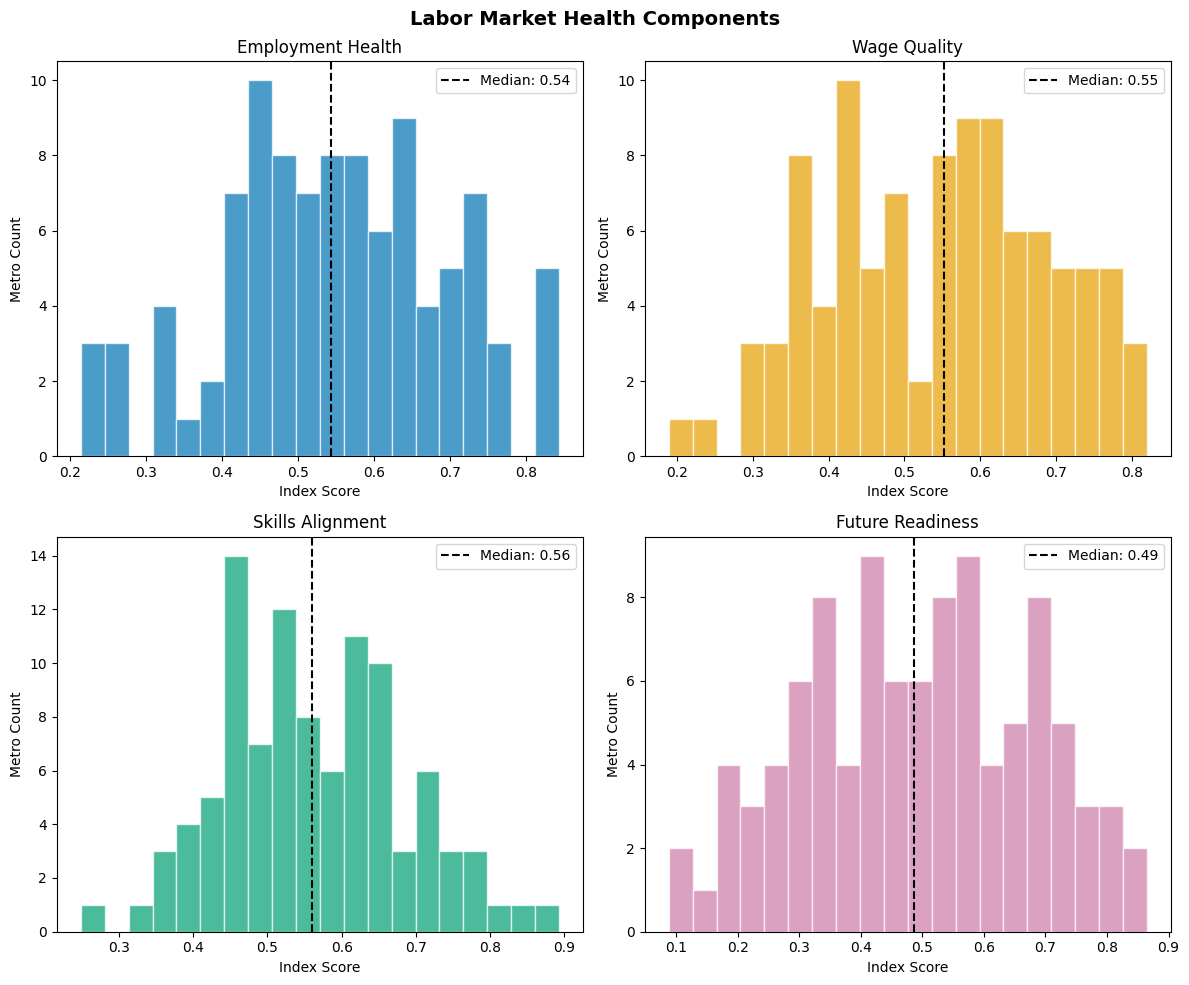

In [7]:
# =============================================================================
# Visualize Labor Market Components
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

components = [
    ('employment_health_index', 'Employment Health'),
    ('wage_quality_index', 'Wage Quality'),
    ('skills_alignment_index', 'Skills Alignment'),
    ('future_readiness_index', 'Future Readiness')
]

for ax, (col, title), color in zip(axes.flatten(), components, COLORBLIND_SAFE):
    ax.hist(indexed_labor[col], bins=20, color=color, alpha=0.7, edgecolor='white')
    ax.axvline(indexed_labor[col].median(), color='black', linestyle='--', 
               label=f'Median: {indexed_labor[col].median():.2f}')
    ax.set_xlabel('Index Score')
    ax.set_ylabel('Metro Count')
    ax.set_title(title)
    ax.legend()

plt.suptitle('Labor Market Health Components', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

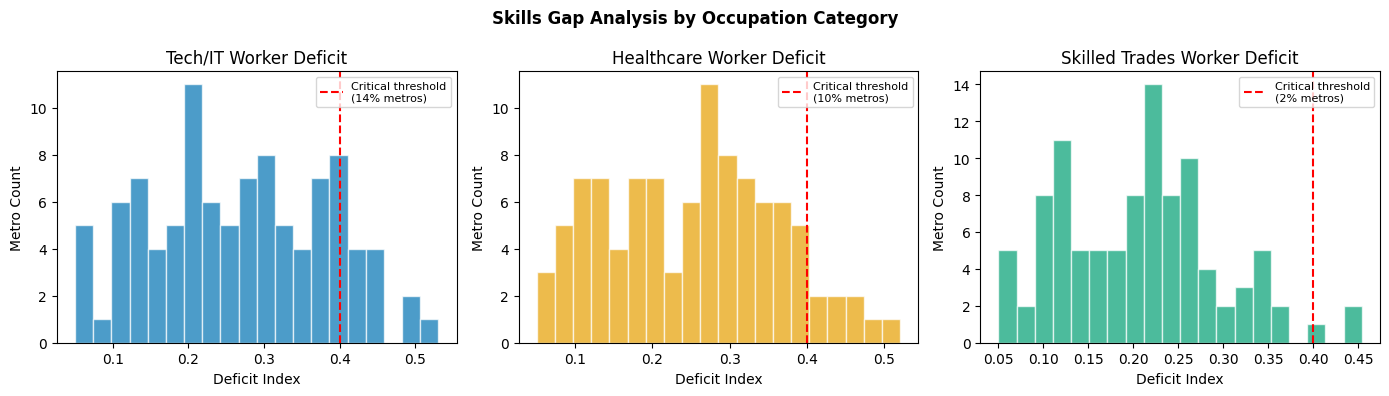

In [8]:
# =============================================================================
# Skills Gap Analysis
# =============================================================================
deficit_cols = ['tech_talent_deficit', 'healthcare_worker_deficit', 'trades_worker_deficit']
deficit_names = ['Tech/IT', 'Healthcare', 'Skilled Trades']

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, col, name, color in zip(axes, deficit_cols, deficit_names, COLORBLIND_SAFE):
    ax.hist(indexed_labor[col], bins=20, color=color, alpha=0.7, edgecolor='white')
    critical_threshold = 0.4
    critical_pct = (indexed_labor[col] > critical_threshold).mean() * 100
    ax.axvline(critical_threshold, color='red', linestyle='--', 
               label=f'Critical threshold\n({critical_pct:.0f}% metros)')
    ax.set_xlabel('Deficit Index')
    ax.set_ylabel('Metro Count')
    ax.set_title(f'{name} Worker Deficit')
    ax.legend(loc='upper right', fontsize=8)

plt.suptitle('Skills Gap Analysis by Occupation Category', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Skills Gap and Automation Risk Analysis

In [9]:
# =============================================================================
# Identify Critical Skills Gaps
# =============================================================================
critical_skills = indexed_labor[
    (indexed_labor['skills_gap_index'] > 0.5) | 
    (indexed_labor['tech_talent_deficit'] > 0.4)
].copy()

print(f"Metros with Critical Skills Gaps: {len(critical_skills)}")
print(f"Population affected: {critical_skills['population'].sum()/1e6:.1f}M")
print(f"\nAverage deficit levels:")
for col, name in zip(deficit_cols, deficit_names):
    print(f"   {name}: {critical_skills[col].mean():.2f}")

# =============================================================================
# Automation Risk Classification
# =============================================================================

def classify_automation_risk(row):
    exposure = row['automation_exposure_pct']
    high_risk = row['high_risk_jobs_pct']
    readiness = row['future_readiness_index']
    
    if exposure > 0.40 and readiness < 0.40:
        return 'Critical Risk'
    elif exposure > 0.35 or (exposure > 0.30 and readiness < 0.45):
        return 'High Risk'
    elif readiness > 0.60:
        return 'Well Prepared'
    elif exposure < 0.25:
        return 'Low Exposure'
    else:
        return 'Moderate Risk'

indexed_labor['automation_risk_class'] = indexed_labor.apply(classify_automation_risk, axis=1)

auto_summary = indexed_labor.groupby('automation_risk_class').agg({
    'metro': 'count',
    'population': 'sum',
    'automation_exposure_pct': 'mean',
    'future_readiness_index': 'mean'
}).round(3)
auto_summary.columns = ['Metros', 'Population', 'Avg Exposure', 'Avg Readiness']

print("\nAutomation Risk Classification:")
auto_summary

Metros with Critical Skills Gaps: 29
Population affected: 20.3M

Average deficit levels:
   Tech/IT: 0.31
   Healthcare: 0.27
   Skilled Trades: 0.17

Automation Risk Classification:


,Metros,Population,Avg Exposure,Avg Readiness
automation_risk_class,,,,
Critical Risk,11,7520417,0.444,0.200
High Risk,27,19508385,0.352,0.348
Low Exposure,9,6720231,0.197,0.557
Moderate Risk,24,16096812,0.291,0.489
Well Prepared,29,22027719,0.206,0.714


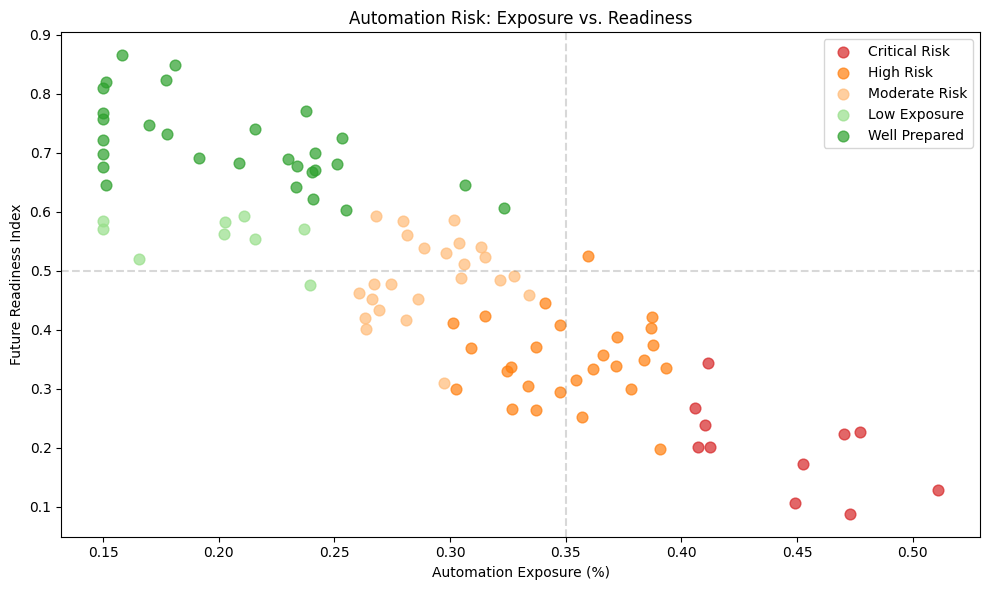

In [10]:
# =============================================================================
# Automation Risk Visualization
# =============================================================================
fig, ax = plt.subplots(figsize=(10, 6))

risk_classes = ['Critical Risk', 'High Risk', 'Moderate Risk', 'Low Exposure', 'Well Prepared']
colors = ['#d62728', '#ff7f0e', '#ffbb78', '#98df8a', '#2ca02c']

for risk, color in zip(risk_classes, colors):
    subset = indexed_labor[indexed_labor['automation_risk_class'] == risk]
    if len(subset) > 0:
        ax.scatter(subset['automation_exposure_pct'], subset['future_readiness_index'],
                  c=color, label=risk, alpha=0.7, s=60)

ax.set_xlabel('Automation Exposure (%)')
ax.set_ylabel('Future Readiness Index')
ax.set_title('Automation Risk: Exposure vs. Readiness')
ax.legend(loc='upper right')
ax.axhline(0.5, color='gray', linestyle='--', alpha=0.3)
ax.axvline(0.35, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Wage Compression Analysis

In [11]:
# =============================================================================
# Wage Compression Analysis
# =============================================================================
from scipy.stats import pearsonr

wage_pressure = indexed_labor[indexed_labor['middle_skill_wage_change'] < 0].copy()

print(f"Metros with declining middle-skill wages: {len(wage_pressure)} ({len(wage_pressure)/len(indexed_labor)*100:.0f}%)")
print(f"Average wage decline: {wage_pressure['middle_skill_wage_change'].mean()*100:.1f}%")

# Correlation with other factors
print(f"\nCorrelations with middle-skill wage change:")
corr_cols = ['automation_exposure_pct', 'college_attainment_pct', 'wage_inequality_ratio']
for col in corr_cols:
    corr, _ = pearsonr(indexed_labor[col], indexed_labor['middle_skill_wage_change'])
    print(f"   {col}: r = {corr:.3f}")

Metros with declining middle-skill wages: 61 (61%)
Average wage decline: -1.8%

Correlations with middle-skill wage change:
   automation_exposure_pct: r = -0.029
   college_attainment_pct: r = 0.103
   wage_inequality_ratio: r = -0.013


## 7. Key Findings Summary

In [12]:
# =============================================================================
# Executive Summary: Key Findings
# =============================================================================
critical_auto = len(indexed_labor[indexed_labor['automation_risk_class'] == 'Critical Risk'])
high_auto = len(indexed_labor[indexed_labor['automation_risk_class'] == 'High Risk'])
auto_pop = indexed_labor[indexed_labor['automation_risk_class'].isin(['Critical Risk', 'High Risk'])]['population'].sum()

avg_skills_gap = indexed_labor['skills_gap_index'].mean()
wage_decline_pct = (indexed_labor['middle_skill_wage_change'] < 0).mean() * 100

print("="*70)
print("LABOR MARKET INTELLIGENCE: KEY FINDINGS")
print("="*70)

print(f"\n🤖 AUTOMATION RISK:")
print(f"   • {critical_auto} metros at Critical Risk")
print(f"   • {high_auto} metros at High Risk")
print(f"   • {auto_pop/1e6:.1f}M workers in high-exposure metros")

print(f"\n📚 SKILLS GAPS:")
print(f"   • Average skills gap index: {avg_skills_gap:.2f}")
print(f"   • {len(critical_skills)} metros with critical skills deficits")

print(f"\n💰 WAGE DYNAMICS:")
print(f"   • {wage_decline_pct:.0f}% of metros show middle-skill wage decline")
print(f"   • Average inequality ratio: {indexed_labor['wage_inequality_ratio'].mean():.1f}x")

print(f"\n💡 POLICY RECOMMENDATIONS:")
print(f"   1. Prioritize upskilling in high-automation-risk metros")
print(f"   2. Expand apprenticeship and credential programs")
print(f"   3. Target tech talent pipeline in deficit areas")
print(f"   4. Support middle-skill wage growth through training")

LABOR MARKET INTELLIGENCE: KEY FINDINGS

🤖 AUTOMATION RISK:
   • 11 metros at Critical Risk
   • 27 metros at High Risk
   • 27.0M workers in high-exposure metros

📚 SKILLS GAPS:
   • Average skills gap index: 0.38
   • 29 metros with critical skills deficits

💰 WAGE DYNAMICS:
   • 61% of metros show middle-skill wage decline
   • Average inequality ratio: 2.6x

💡 POLICY RECOMMENDATIONS:
   1. Prioritize upskilling in high-automation-risk metros
   2. Expand apprenticeship and credential programs
   3. Target tech talent pipeline in deficit areas
   4. Support middle-skill wage growth through training


## Limitations & Interpretation

### What This Analysis DOES Show

1. **Current Labor Market Conditions**
   - Employment levels and trends across industries
   - Wage distributions and changes over time
   - Unemployment rate dynamics and seasonality

2. **Regional Industry Patterns**
   - Location quotients identify relative specialization
   - Shift-share decomposes growth into national/industry/regional components
   - Skill distribution across metro areas

3. **Correlational Relationships**
   - Association between unemployment and macroeconomic indicators
   - Co-movement of wages and cost-of-living measures
   - Seasonal patterns in employment

4. **Anomaly Detection**
   - Unusual deviations from expected seasonal patterns
   - Structural breaks in employment trends
   - Early warning signals of labor market stress

### What This Analysis DOES NOT Show

1. **Causal Effects**
   - Correlations ≠ causation
   - Cannot determine if policy X *caused* employment change Y
   - Confounding factors may explain observed associations

2. **Counterfactual Outcomes**
   - What would have happened without intervention
   - Whether alternative policies would perform better
   - Optimal policy design

3. **Individual-Level Heterogeneity**
   - Aggregate statistics may mask important subgroup variation
   - Average wage trends don't reflect distributional changes
   - Metro-level analysis misses neighborhood effects

4. **Structural Interpretation**
   - Why industries specialize in certain regions
   - Whether specialization is beneficial or risky
   - Causal drivers of regional competitiveness

### Common Misinterpretations to AVOID

| ❌ Incorrect Interpretation | ✅ Correct Interpretation |
|----------------------------|--------------------------|
| "Unemployment dropped *because* GDP grew" | "Unemployment and GDP are negatively correlated" |
| "Training programs work—skills improved" | "Regions with training programs have higher skills on average" |
| "This metro *should* invest in tech" | "This metro has lower tech specialization than peers" |
| "The policy caused the recovery" | "Recovery coincided with policy implementation" |

### Appropriate Uses of This Analysis

**✅ Appropriate:**
- Monitoring economic conditions in real-time
- Identifying regions for further investigation
- Contextualizing causal studies
- Generating hypotheses for rigorous testing
- Benchmarking against peers

**❌ Not Appropriate:**
- Claiming policy caused observed outcomes
- Recommending specific interventions
- Predicting effects of untested policies
- Cost-benefit analysis (requires causal estimates)

### Reproducibility Notes

**Random Seed:** Not applicable (real data; no stochastic elements)

**Data Versioning:** FRED and BLS data are vintaged; results may differ if re-run with revised data. Consider saving raw data snapshots for full reproducibility.

**API Rate Limits:** BLS and FRED have rate limits. For production use, implement caching and backoff strategies.

### Recommended Next Steps

1. **For Causal Questions:** Use causal inference methods (see notebooks 14, 15, 22)
2. **For Prediction:** Develop time series forecasting models
3. **For Deep Dives:** Disaggregate to county or tract level
4. **For Comparison:** Extend to additional metros or time periods

## References

### Labor Market Analysis Methods

1. **Bartik, T. J. (1991).** Who Benefits from State and Local Economic Development Policies? W.E. Upjohn Institute.
   - Foundation for shift-share analysis and local labor demand estimation

2. **Moretti, E. (2010).** Local Multipliers. *American Economic Review: Papers & Proceedings*, 100(2), 373-377.
   - Employment multipliers across sectors; tradable vs. non-tradable

3. **Autor, D. H., Dorn, D., & Hanson, G. H. (2013).** The China Syndrome: Local Labor Market Effects of Import Competition. *American Economic Review*, 103(6), 2121-2168.
   - Shift-share instrumental variables approach

4. **Katz, L. F., & Murphy, K. M. (1992).** Changes in Relative Wages, 1963–1987: Supply and Demand Factors. *Quarterly Journal of Economics*, 107(1), 35-78.
   - Labor supply and demand decomposition framework

5. **Cleveland, R. B., Cleveland, W. S., McRae, J. E., & Terpenning, I. (1990).** STL: A Seasonal-Trend Decomposition Procedure Based on Loess. *Journal of Official Statistics*, 6(1), 3-73.
   - STL decomposition methodology for time series

### Data Sources and Documentation

6. **Bureau of Labor Statistics.** Current Employment Statistics (CES).
   - Source: https://www.bls.gov/ces/
   - Monthly establishment-level employment by industry

7. **Bureau of Labor Statistics.** Quarterly Census of Employment and Wages (QCEW).
   - Source: https://www.bls.gov/qcew/
   - Comprehensive employment and wage data from administrative records

8. **Federal Reserve Economic Data (FRED).**
   - Source: https://fred.stlouisfed.org/
   - Macroeconomic indicators including GDP, CPI, unemployment

9. **O*NET Resource Center.**
   - Source: https://www.onetcenter.org/
   - Occupational characteristics, automation exposure metrics

### Regional Economics

10. **Glaeser, E. L., & Gottlieb, J. D. (2009).** The Wealth of Cities: Agglomeration Economies and Spatial Equilibrium in the United States. *Journal of Economic Literature*, 47(4), 983-1028.
    - Spatial equilibrium and regional wage differentials

11. **Autor, D. H. (2019).** Work of the Past, Work of the Future. *AEA Papers and Proceedings*, 109, 1-32.
    - Labor market polarization and geographic divergence

### KRL Suite Documentation

12. **KRL Suite v2.0 Documentation.**
    - Source: Internal documentation
    - `BLSBasicConnector`, `FREDBasicConnector`, `LocationQuotientModel`, `ShiftShareModel`, `STLAnomalyModel` APIs

---

## Appendix: KRL Suite Components Used

| Package | Components | Role |
|---------|------------|------|
| **krl-data-connectors** | `BLSBasicConnector`, `FREDBasicConnector` | Labor and economic data |
| **krl-models** | `LocationQuotientModel`, `ShiftShareModel`, `STLAnomalyModel` | Industry and time-series analysis |
| **krl-core** | `get_logger` | Infrastructure utilities |

### Production Data Sources

For production deployment, connect to:
- **BLS Current Employment Statistics** - Employment by industry
- **BLS Occupational Employment Statistics** - Wage data
- **BLS Quarterly Census of Employment and Wages** - County-level detail
- **O*NET** - Occupation characteristics and automation exposure

### Example Production Usage

```python
from krl_data_connectors.community import BLSBasicConnector
from krl_models import LocationQuotientModel

bls = BLSBasicConnector()
unemployment = bls.get_unemployment_rate()
cpi = bls.get_cpi()

# Industry specialization analysis
lq = LocationQuotientModel()
lq.fit(employment_data)
specialized = lq.get_specialized_industries(region='12060', threshold=1.5)
```

---
*Generated with KRL Suite v2.0 - Community Edition*